# Overview  <a name='objectives' />

This notebook introduces you to Dimensionality Reduction. We will start with some exercises using Principal Component Analysis (PCA) on a very simple dataset, and later move on to using PCA on a more complicated dataset. This is followed by an exercise on using Singular Value Decomposition in PCA. The final exercise will be on Linear Discriminant Analysis (LDA).

The topics that will be covered are:

1. <a href=#pca>PCA with a Toy dataset</a>
2. <a href=#pca_iris>PCA with the Iris dataset</a>
3. <a href=#pca_svd>PCA with SVD</a>
4. <a href=#lda>LDA</a>

### Programming Tasks
For the programming tasks you will need to replace the following comment and exception with your own code:

```python
# YOUR CODE HERE
raise NotImplementedError()
```

Most programming tasks are followed by a cell with tests (using the `assert` function from python). You can use these cells while developing your implementation and for validating your implementation.

In [1]:
# DO NOT INSTALL THE LIBRARIES WHEN WORKING ON ifi-europa.uibk.ac.at

# Make sure that the required libraries are installed
# If you are using Google Colab, remember to upload the requirements file before 
# running this cell
# If you are running this notebook locally, the requirements file needs to be in 
# the same location as this notebook
import os
running_local = True if os.getenv('JUPYTERHUB_USER') is None else False
    
if running_local:
    import sys
    !{sys.executable} -m pip install -r requirements_week07.txt

You should consider upgrading via the '/home-local/sayantan/venv/venv-rl/bin/python -m pip install --upgrade pip' command.


In [2]:
# Necessary imports
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')
from collections import OrderedDict
from mpl_toolkits.mplot3d import Axes3D
import gzip
np.random.seed(10)

<a href=#objectives> [go to top] </a>
## Part 1: Principal Component Analysis with a Toy dataset <a name='pca' />

Recall from the lecture that the objective of Principal Component Analyis (PCA) is the following:

*Given data points in m-dimensional space, project them into a lower dimensional space while preserving as much information as possible.*

To demonstrate the effect of PCA, first, we are going to work with a small 2-dimensional toy dataset. The dataset is generated by sampling some points from a 2D Gaussian distribution with 0 mean and a covariance matrix that shows a grater spread in one of the two dimensions.

In [3]:
# Generate 100 data points for our toy dataset and note the shape of the dataset
mean = [0, 0]
cov = [[1, 0.8], [0.8, 1]]

x0, x1 = np.random.multivariate_normal(mean, cov, 100).T
x = np.concatenate((np.expand_dims(x0,-1),np.expand_dims(x1,-1)), axis=1)
print(x.shape)

(100, 2)


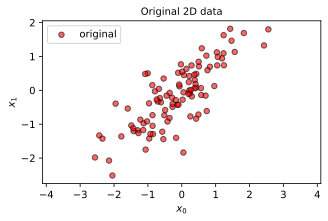

In [4]:
# Plot the original 2D data
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('$x_0$', fontsize = 10)
ax.set_ylabel('$x_1$', fontsize = 10)
ax.set_title('Original 2D data', fontsize = 10)
ax.scatter(x[:,0], x[:,1], c = 'r', s = 30, alpha=0.6, edgecolors='black', label='original')
ax.legend()
ax.axis('equal')
plt.show()

### Task 1.1: PCA Dimensionality Reduction

Given this 2D dataset $X$, now we want to project it into a 1-dimensional space using PCA. To do this, follow the following steps:

1. Center the data $X$ by subtracting the mean to get $\hat{X}$.
2. Calculate the covariance matrix of $\hat{X}$.
3. Compute the eigenvectors and eigenvalues using the covariance matrix.
4. Compute the matrix containing the `reduced_dim` largest eigenvectors (first `reduced_dim` columns). This is ordered by the eigenvalues.
5. Compute $X_{\text{projected}}$, the projection of $\hat{X}$ onto the PCA basis.

These steps are performed by the function below. Complete this function.

In [5]:
def pca_reduce(x, reduced_dim):
    """
    Reduces the dimensions of the input data x (shape: [num_observations, orig_dim])
    from orig_dim to reduced_dim

    :param: x: input data (shape: [num_observations, orig_dim])
    :param: reduced_dim: int representing the reduced dimension

    :returns:
        x_projected: data of reduced dimension (numpy array of shape: [num_observations, reduced_dim])
        eigVecs: eigen vectors (shape: [orig_dim, orig_dim])
        W: matrix with first `reduced_dim` eigen vectors along the columns (shape: [orig_dim, reduced_dim])
        x_mean: mean of the input data (shape: [orig_dim,])
    """
    # 1. Center the data by subtracting the mean (`x_mean`) of the whole dataset to get `x_centered`

    # 2. Calculate the covariance matrix of `x_centered`
    # Use `np.cov` with rowvar=False
    # rowvar=False: each column represents a dimension, while the rows contain observations
    # check https://docs.scipy.org/doc/numpy/reference/generated/numpy.cov.html
    
    # 3. Compute the eigenvalues and eigenvectors (`eigVals`, `eigVecs`)
    # Use `np.linalg.eig`
    
    # 4. Compute the matrix `W` containing `reduced_dim` largest eigenvectors 
    # (first `reduced_dim` columns of the eigenvectors sorted according to the eigenvalues)
    
    # 5. Compute `x_projected`, the projection of x_centered onto the PCA basis by the dot product of 
    # `x_centered` and `W`
    
    ### BEGIN SOLUTION
    
    x_mean = np.mean(x, axis=0)
    x_centered = x - x_mean
    
    cov = np.cov(x_centered, rowvar=False)
    
    eigVals, eigVecs = np.linalg.eig(cov)
    
    idx = eigVals.argsort()[::-1]  
    W = eigVecs[:, idx[0:reduced_dim]]
    
    x_projected = np.dot(x_centered, W)
    
    ### END SOLUTION

    return x_projected, eigVecs, W, x_mean

In [6]:
# Test the PCA function
x_reduced, eigVecs, W, x_mean = pca_reduce(x, reduced_dim=1)
assert x_reduced.shape==(100,1), \
f"x_reduced should have the shape (100,1) but instead it is {x_reduced.shape}"

### Task 1.2: PCA Reconstruction

Since we want to see visually how well PCA performs, complete the below function which reprojects the low-dimensional data (which we get using PCA) into the original higher dimensional space.

In [7]:
def pca_reconstruct(x_reduced, W, x_mean):
    """
    Reprojects the low-dimensional data into the original space

    :param: x_reduced: data of reduced dimension (numpy array of shape: [num_observations, reduced_dim])
    :param: W: matrix with first `reduced_dim` eigen vectors along the columns (shape: [orig_dim, reduced_dim])
    :param: x_mean: mean of the input data (shape: [orig_dim,])

    returns: x_reconstructed: reprojected data (shape: [num_observations, orig_dim])
    """
    # Reproject `x_reduced` into the original space
    # x_reconstructed = dot product of x_reduced and W.T + the mean vector of the original data
    
    ### BEGIN SOLUTION
    
    x_reconstructed = np.dot(x_reduced, W.T) + x_mean    
    
    ### END SOLUTION
    
    return x_reconstructed

In [8]:
# Test PCA reconstruction
x_reconstructed = pca_reconstruct(x_reduced, W, x_mean)
assert x_reconstructed.shape==(100,2), \
f"x_reconstructed should have the shape (100,2) but instead it is {x_reconstructed.shape}"

### Task 1.3: PCA Reconstruction Error

Once we have reprojected the low-dimensional data into the original high dimensional space, we need to check how much information we have lost. This can be done by computing the reconstruction error, whcih is given by the mean squared error between the original dataset and the reconstructed dataset.


In [9]:
def pca_reconstruction_error(x, x_reconstructed):
    """
    Computes the reconstruction error for PCA

    :param: x: input data (shape: [num_observations, orig_dim])
    :param: x_reconstructed: reprojected data (shape: [num_observations, orig_dim])
    
    :returns: scalar error
    """
    ### BEGIN SOLUTION
    
    error = np.mean((x - x_reconstructed)**2)

    ### END SOLUTION
    
    return error

In [10]:
# Test reconstruction error 
error = pca_reconstruction_error(x, x_reconstructed)
assert np.isscalar(error), f"{error} is not a scalar"

### Some Properties of PCA

* Because $\Sigma$ is symmetric, any two eigenvectors with different eigenvalues are orthogonal.
* Since $\Sigma$ is positive semidefinite ($\mathbf{x}^{\mathrm{T}} \Sigma \mathbf{x} \ge 0$ for all non-null $\mathbf{x}$), then all its eigenvalues are nonnegative.
* If $\Sigma$ is singular, then its rank is $K \lt D$, and $\lambda_i = 0$ for $i = K + 1, \dots, D$.
* The $K$ eigenvectors with nonzero eigenvalues are the dimensions of the transformed space.
* The first eigenvector (principal component) explains the largest part of the variance, and so on.
* The eigenvalues give the variances of the data along the principal components.

### PCA in action on our Toy dataset

Now let us reduce our toy 2D dataset into 1D and check visually what the reconstructed data looks like.

In [11]:
# Reduce from 2D to 1D
x_reduced, eigVecs, W, x_mean = pca_reduce(x, reduced_dim=1)
print(x_reduced.shape)

(100, 1)


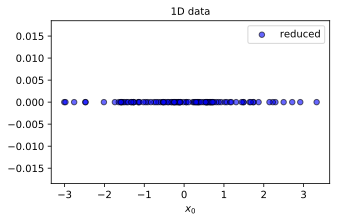

In [12]:
# Plot the 1D data
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('$x_0$', fontsize = 10)
ax.set_title('1D data', fontsize = 10)
ax.scatter(x_reduced[:,0], 
           np.zeros(x_reduced.shape), 
           c='b', 
           s=30, 
           alpha=0.6,
           edgecolors='black', 
           label='reduced')
ax.legend()
plt.show()

In [13]:
# Reproject the reduced 1D data into 2D space
x_reconstructed = pca_reconstruct(x_reduced, W, x_mean)

# Compute the reconstruction error
error = pca_reconstruction_error(x, x_reconstructed)
print(f'Reconstruction error: {error:.5f}')

Reconstruction error: 0.09328


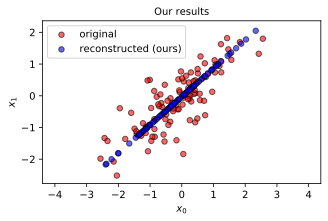

In [14]:
# Plot the original points and the reconstructed points together
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('$x_0$', fontsize = 10)
ax.set_ylabel('$x_1$', fontsize = 10)
ax.set_title('Our results', fontsize = 10)
ax.scatter(x[:,0], x[:,1], 
           c = 'r', s = 30, edgecolors='black', alpha=0.6, label='original')
ax.scatter(x_reconstructed[:,0], 
           x_reconstructed[:,1], 
           c = 'b', s = 30, alpha=0.6, edgecolors='black', label='reconstructed (ours)')
ax.legend()
ax.axis('equal')
plt.show()

### Task 1.4: PCA with Scikit

Using the same toy dataset, use the PCA function from scikit and check if you get the same results.

In [15]:
# Compare our result with scikit
from sklearn import decomposition

# 1. Create a pca object using decomposition.PCA with n_components=1
# 2. Use the object created in the previous step to fit the data `x`
# 3. Call the `transform` method of the pca object to get `x_reduced_scikit` 
# 4. Call the `inverse_transform` method of the pca object to get `x_reconstructed_scikit`

x_reconstructed_scikit = None

### BEGIN SOLUTION

pca = decomposition.PCA(n_components=1, )
pca.fit(x)
x_reduced_scikit = pca.transform(x)
x_reconstructed_scikit = pca.inverse_transform(x_reduced_scikit)

### END SOLUTION

# Check the reconstruction error using scikit
scikit_error = pca_reconstruction_error(x, x_reconstructed_scikit)
print(f'Scikit error: {scikit_error:.5f}')

Scikit error: 0.09328


In [16]:
# Test the scikit code
assert np.allclose(error, scikit_error, atol=0.01), \
f"Custom PCA error {error:.5f} does not match scikit error {scikit_error:.5f}"

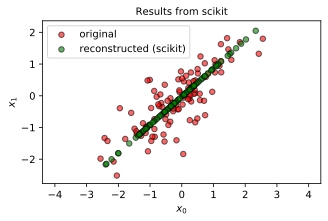

In [17]:
# Plot the original points and the reconstructed points together
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('$x_0$', fontsize = 10)
ax.set_ylabel('$x_1$', fontsize = 10)
ax.set_title('Results from scikit', fontsize = 10)
ax.scatter(x[:,0], x[:,1], 
           c = 'r', s = 30, alpha=0.6, edgecolors='black', label='original')
ax.scatter(x_reconstructed_scikit[:,0], x_reconstructed_scikit[:,1], 
           c = 'g', s = 30, alpha=0.6, edgecolors='black', label='reconstructed (scikit)')
ax.legend()
ax.axis('equal')
plt.show()

<a href=#objectives> [go to top] </a>
## Part 2: Principal Component Analysis with the Iris dataset<a name='pca_iris' />

Now we will move on to using PCA on a real dataset called the Iris dataset (more information about the dataset can be found [here](https://en.wikipedia.org/wiki/Iris_flower_data_set)). The data consists of 150 data points and each data point contains 4 numerical attributes. Each data point belongs to one out of 3 classes.

First, load the dataset into numpy arrays using the code given below.

In [18]:
if running_local:
    # If you are running the notebook locally, make sure you have downloaded
    # the iris.data file in the same location as the notebook
    iris_data = np.loadtxt('iris.data', delimiter=',', dtype='str')
else:
    iris_data = np.loadtxt('/data/Iris/iris.data', delimiter=',', dtype='str')
    
x_iris = iris_data[:, 0:4].astype(np.float)
y_iris_str = np.expand_dims(iris_data[:, 4], -1)  # Iris labels as strings
y_iris = np.where([np.unique(y_iris_str)==y_iris_str])[2].reshape(-1,1)  # Iris labels as integers

After the data is loaded, check the shape of the data and labels, the value of the different labels and view some data points from the dataset.

In [19]:
# Check the shape of the data and the labels
print(f'Shape of x_iris: {x_iris.shape}')
print(f'Shape of y_iris: {y_iris.shape}')

Shape of x_iris: (150, 4)
Shape of y_iris: (150, 1)


In [20]:
# Check unique labels
print(f'Unique labels: {np.unique(y_iris)}')
print(f'Unique label strings: {np.unique(y_iris_str)}')

Unique labels: [0 1 2]
Unique label strings: ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


In [21]:
# Check samples from x_iris and y_iris
random_idx = np.random.choice(150, 5)
print(f'x: {x_iris[random_idx]}')
print(f'y: {y_iris[random_idx]}')
print(f'y_str: {y_iris_str[random_idx]}')

x: [[4.9 3.1 1.5 0.1]
 [5.2 3.5 1.5 0.2]
 [6.9 3.1 4.9 1.5]
 [5.5 2.6 4.4 1.2]
 [4.9 2.4 3.3 1. ]]
y: [[0]
 [0]
 [1]
 [1]
 [1]]
y_str: [['Iris-setosa']
 ['Iris-setosa']
 ['Iris-versicolor']
 ['Iris-versicolor']
 ['Iris-versicolor']]


### Task 2.1: PCA for the Iris dataset

Using the `pca_reduce` function that you wrote earlier, perform PCA dimensionality reduction on the Iris dataset. Since the original dataset is 4-dimensional, we will try to see what the reduced data looks like when we reduce the 4D data into 1D, 2D and 3D and 4D (just to check how much of the original data we can recover).

In [22]:
# Reduce the dimension of the original data x_iris into 1D, 2D, 3D and 4D (no reduction)

# For 1D, use the variables `x_iris_1d_pca`, `eigVecs_iris_1d_pca`, `W_iris_1d_pca`, `x_mean_iris_1d_pca`
# For 2D, use the variables `x_iris_2d_pca`, `eigVecs_iris_2d_pca`, `W_iris_2d_pca`, `x_mean_iris_2d_pca`
# For 3D, use the variables `x_iris_3d_pca`, `eigVecs_iris_3d_pca`, `W_iris_3d_pca`, `x_mean_iris_3d_pca`
# For 4D, use the variables `x_iris_4d_pca`, `eigVecs_iris_4d_pca`, `W_iris_4d_pca`, `x_mean_iris_4d_pca`

### BEGIN SOLUTION

x_iris_1d_pca, eigVecs_iris_1d_pca, W_iris_1d_pca, x_mean_iris_1d_pca = pca_reduce(x_iris, reduced_dim=1)
x_iris_2d_pca, eigVecs_iris_2d_pca, W_iris_2d_pca, x_mean_iris_2d_pca = pca_reduce(x_iris, reduced_dim=2)
x_iris_3d_pca, eigVecs_iris_3d_pca, W_iris_3d_pca, x_mean_iris_3d_pca = pca_reduce(x_iris, reduced_dim=3)
x_iris_4d_pca, eigVecs_iris_4d_pca, W_iris_4d_pca, x_mean_iris_4d_pca = pca_reduce(x_iris, reduced_dim=4)

### END SOLUTION

# Check the shape of the returned values
print(f'Shape of x_iris_1d_pca: {x_iris_1d_pca.shape}')
print(f'Shape of eigVecs_iris_1d_pca: {eigVecs_iris_1d_pca.shape}')
print(f'Shape of W_iris_1d_pca: {W_iris_1d_pca.shape}')
print(f'Shape of x_mean_iris_1d_pca: {x_mean_iris_1d_pca.shape}')
print('#############')
print(f'Shape of x_iris_2d_pca: {x_iris_2d_pca.shape}')
print(f'Shape of eigVecs_iris_2d_pca: {eigVecs_iris_2d_pca.shape}')
print(f'Shape of W_iris_2d_pca: {W_iris_2d_pca.shape}')
print(f'Shape of x_mean_iris_2d_pca: {x_mean_iris_2d_pca.shape}')
print('#############')
print(f'Shape of x_iris_3d_pca: {x_iris_3d_pca.shape}')
print(f'Shape of eigVecs_iris_3d_pca: {eigVecs_iris_3d_pca.shape}')
print(f'Shape of W_iris_3d_pca: {W_iris_3d_pca.shape}')
print(f'Shape of x_mean_iris_3d_pca: {x_mean_iris_3d_pca.shape}')
print('#############')
print(f'Shape of x_iris_4d_pca: {x_iris_4d_pca.shape}')
print(f'Shape of eigVecs_iris_4d_pca: {eigVecs_iris_4d_pca.shape}')
print(f'Shape of W_iris_4d_pca: {W_iris_4d_pca.shape}')
print(f'Shape of x_mean_iris_4d_pca: {x_mean_iris_4d_pca.shape}')

Shape of x_iris_1d_pca: (150, 1)
Shape of eigVecs_iris_1d_pca: (4, 4)
Shape of W_iris_1d_pca: (4, 1)
Shape of x_mean_iris_1d_pca: (4,)
#############
Shape of x_iris_2d_pca: (150, 2)
Shape of eigVecs_iris_2d_pca: (4, 4)
Shape of W_iris_2d_pca: (4, 2)
Shape of x_mean_iris_2d_pca: (4,)
#############
Shape of x_iris_3d_pca: (150, 3)
Shape of eigVecs_iris_3d_pca: (4, 4)
Shape of W_iris_3d_pca: (4, 3)
Shape of x_mean_iris_3d_pca: (4,)
#############
Shape of x_iris_4d_pca: (150, 4)
Shape of eigVecs_iris_4d_pca: (4, 4)
Shape of W_iris_4d_pca: (4, 4)
Shape of x_mean_iris_4d_pca: (4,)


In [23]:
# Test for PCA on the Iris dataset
correct_shapes = {'x_iris_1d_pca': (x_iris_1d_pca, (150,1)),
                  'x_iris_2d_pca': (x_iris_2d_pca, (150,2)),
                  'x_iris_3d_pca': (x_iris_3d_pca, (150,3)),
                  'x_iris_4d_pca': (x_iris_4d_pca, (150,4)),
                  'W_iris_1d_pca': (W_iris_1d_pca, (4,1)),
                  'W_iris_2d_pca': (W_iris_2d_pca, (4,2)),
                  'W_iris_3d_pca': (W_iris_3d_pca, (4,3)),
                  'W_iris_4d_pca': (W_iris_4d_pca, (4,4)),
                  'eigVecs_iris_1d_pca': (eigVecs_iris_1d_pca, (4,4)),
                  'eigVecs_iris_2d_pca': (eigVecs_iris_2d_pca, (4,4)),
                  'eigVecs_iris_3d_pca': (eigVecs_iris_3d_pca, (4,4)),
                  'eigVecs_iris_4d_pca': (eigVecs_iris_4d_pca, (4,4))}

for k,v in correct_shapes.items():
    assert v[0].shape==v[1], f"Shape of {k} should be {v[1]} but is {v[0].shape}"

Provided below is a function that can plot the reduced datasets in 1D, 2D or 3D. Don't worry about the details of this function.

In [24]:
# Plotting functions for plotting 1D, 2D and 3D data
    
def plot_123D(x_reduced, y, y_labels=None, colors = ['r', 'g', 'b'], figsize=(5,3), alpha=0.6, title='PCA'):
    
    assert x_reduced.shape[1] in np.array([1,2,3]), 'This function can only plot 1D, 2D or 3D data'

    # Determine type of plot - 1D, 2D or 3D
    plot_type = x_reduced.shape[1]     

    if y_labels is None:
        y_labels = y

    # Get unique labels
    y_unique = np.unique(y)
    y_unique_str = np.unique(y_labels)
    
    fig = plt.figure(figsize = figsize)
    ax = fig.add_subplot(1,1,1, projection='3d' if plot_type==3 else None) 
    ax.set_xlabel('Principal Component 1', fontsize = 10)
    if plot_type == 2 or plot_type == 3:
        ax.set_ylabel('Principal Component 2', fontsize = 10)
    if plot_type == 3:
        ax.set_zlabel('Principal Component 3', fontsize = 10)
    ax.set_title(f'{plot_type} Component {title}', fontsize = 10)
    
    if plot_type==2:
        xmin,xmax = np.min(x_reduced, axis=0)[0], np.max(x_reduced, axis=0)[0]
        ymin,ymax = np.min(x_reduced, axis=0)[1], np.max(x_reduced, axis=0)[1]
        xmin -= 0.2*abs(xmin)
        xmax += 0.2*abs(xmax)
        ymin -= 0.2*abs(ymin)
        ymax += 0.2*abs(ymax)
        ax.set_xlim((xmin,xmax))
        ax.set_ylim((ymin,ymax))

    # Scatter plot for each class separately
    for y_ in y_unique:
        x0 = x_reduced[(y==y_).ravel(), 0]
        if plot_type == 1:
            x1 = np.zeros(x0.shape)
        elif plot_type == 2:
            x1 = x_reduced[(y==y_).ravel(), 1]
        elif plot_type == 3:
            x1 = x_reduced[(y==y_).ravel(), 1]
            x2 = x_reduced[(y==y_).ravel(), 2]
        label = y_unique_str[y_]
        color = colors[y_]
        if plot_type == 1 or plot_type == 2:
            ax.scatter(x0[:], x1[:], 
                       c = color, s = 30, alpha=alpha, label=label, edgecolors='black')
        elif plot_type == 3:
            ax.scatter(x0[:], x1[:], x2[:],
                       c = color, s = 30, alpha=alpha, label=label, edgecolors='black')
        
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    ax.grid()
    #if plot_type != 3:
        #ax.axis('equal')

Now let's plot the various reduced datasets that you computed from the Iris dataset (originally 4D).

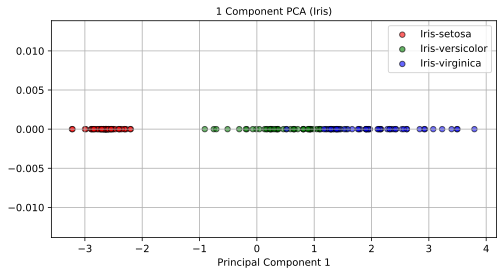

In [25]:
# Plot the 1D data
plot_123D(x_iris_1d_pca, y_iris, y_iris_str, colors = ['r', 'g', 'b'], 
          figsize=(8,4), alpha=0.6, title='PCA (Iris)')

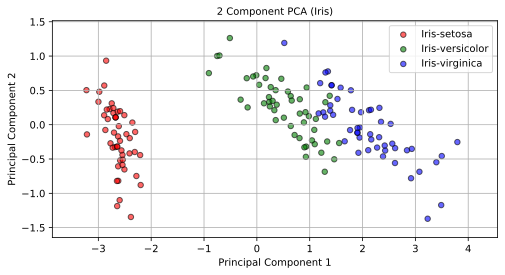

In [26]:
# Plot the 2D data
plot_123D(x_iris_2d_pca, y_iris, y_iris_str, colors = ['r', 'g', 'b'],
         figsize=(8,4), alpha=0.6, title='PCA (Iris)')

If your code is correct till this point, you should be able to see three clusters corresponding to the three classes more or less clearly in the above plot.

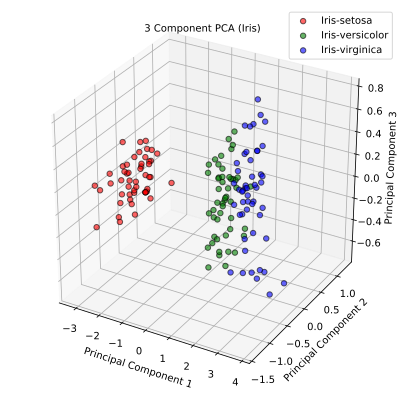

In [27]:
# Plot the 3D data
plot_123D(x_iris_3d_pca, y_iris, y_iris_str, colors = ['r', 'g', 'b'], 
          figsize=(7,7), alpha=0.6, title='PCA (Iris)')

### Task 2.2: PCA reconstruction error for the Iris dataset

Compute the reconstruction errors for the Iris dataset when using PCA for the 1D, 2D, 3D and 4D case.

In [28]:
# 1. Compute the reprojected points for 1D, 2D, 3D and 4D into the original space (4D)
#    Use `pca_reconstruct` and appropriate arguments
# 2. Compute the reconstruction errors for 1D, 2D, 3D and 4D
#    Call `pca_reconstruction_error`, and use `x_iris` and the reconstructed points computed from step 1
#    as arguments

iris_1d_pca_error = np.inf
iris_2d_pca_error = np.inf
iris_3d_pca_error = np.inf
iris_4d_pca_error = np.inf

### BEGIN SOLUTION

x_iris_1d_pca_reconst = pca_reconstruct(x_iris_1d_pca, W_iris_1d_pca, x_mean_iris_1d_pca)
x_iris_2d_pca_reconst = pca_reconstruct(x_iris_2d_pca, W_iris_2d_pca, x_mean_iris_2d_pca)
x_iris_3d_pca_reconst = pca_reconstruct(x_iris_3d_pca, W_iris_3d_pca, x_mean_iris_3d_pca)
x_iris_4d_pca_reconst = pca_reconstruct(x_iris_4d_pca, W_iris_4d_pca, x_mean_iris_4d_pca)

iris_1d_pca_error = pca_reconstruction_error(x_iris, x_iris_1d_pca_reconst)
iris_2d_pca_error = pca_reconstruction_error(x_iris, x_iris_2d_pca_reconst)
iris_3d_pca_error = pca_reconstruction_error(x_iris, x_iris_3d_pca_reconst)
iris_4d_pca_error = pca_reconstruction_error(x_iris, x_iris_4d_pca_reconst)  # Should be very close to 0

### END SOLUTION

print(f'Reconstruction error for 1D: {iris_1d_pca_error:.6f}')
print(f'Reconstruction error for 2D: {iris_2d_pca_error:.6f}')
print(f'Reconstruction error for 3D: {iris_3d_pca_error:.6f}')
print(f'Reconstruction error for 4D: {iris_4d_pca_error:.6f}')

Reconstruction error for 1D: 0.085539
Reconstruction error for 2D: 0.025381
Reconstruction error for 3D: 0.005881
Reconstruction error for 4D: 0.000000


In [29]:
# Test the reconstruction errors

assert iris_1d_pca_error>iris_2d_pca_error>iris_3d_pca_error>iris_4d_pca_error,\
       "Reconstruction errors should be in the order 1D>2D>3D>4D"

assert np.allclose(iris_1d_pca_error, 0.0, atol=0.1), \
       f"Value of iris_1d_pca_error={iris_1d_pca_error} is too high"
assert np.allclose(iris_2d_pca_error, 0.0, atol=0.03), \
       f"Value of iris_2d_pca_error={iris_2d_pca_error} is too high"
assert np.allclose(iris_3d_pca_error, 0.0, atol=0.01), \
       f"Value of iris_3d_pca_error={iris_3d_pca_error} is too high"
assert np.allclose(iris_4d_pca_error, 0.0), \
       f"Value of iris_4d_pca_error={iris_4d_pca_error} is too high"

<a href=#objectives> [go to top] </a>
## Part 3: Principal Component Analysis with Singular Value Decomposition<a name='pca_svd' />

Previously in task 1.1 you performed dimensionality reduction using PCA by explicitly computing the covariance matrix and then computing the eigenvalues and the eigenvectors using the covariance matrix. 

### Task 3.1: PCA with SVD for the Iris dataset

An alternate way of performing dimensionality reduction with PCA is to use Singular Value Decomposition (SVD). This is usually the preferred approach when the covariance matrix is huge. The steps for PCA with SVD (as discussed in the lecture) are:

1. Center the data $X$ by subtracting the mean to get $\hat{X}$ (each row should be 1 data point)
2. Solve SVD: $\hat{X}$ = $USV^T$
3. Output Principle components: columns of $V$ ( = rows of $V^T$ )

These steps should be performed by the function below. Complete this function.

In [30]:
def pca_reduce_svd(x, reduced_dim):
    """
    Performs PCA dimensionality reduction using SVD

    :param: x: input data (shape: [num_observations, orig_dim])
    :param: reduced_dim: The lower dimension to reduce the data to
    
    :returns: x_projected: The projected low-dimensional data (shape: [num_observations, reduced_dim])
              VT:  Returned from np.linalg.svd (shape: [orig_dim, orig_dim])
              VT_reduced: The first `reduced_dim` rows of VT (shape: [reduced_dim, orig_dim])
              x_mean: The mean vector (shape: [orig_dim,])
    """
    
    # 1. Compute the mean
    # 2. `x_centered` = center the data `x` by subtracting the mean 
    # 3. Compute `U`, `S` and `VT` using the centered data. Use the function `np.linalg.svd`
    # 4. Select the first `reduced_dim` rows of `VT` and store in `VT_reduced`
    # 5. Compute the dot product of `x_centered` and the transpose of `VT_reduced` to get `x_projected`
    
    ### BEGIN SOLUTION
    
    x_mean = np.mean(x, axis=0)
    
    x_centered = x - x_mean
    
    U, S, VT = np.linalg.svd(x_centered)
        
    VT_reduced = VT[:reduced_dim, :]
            
    x_projected = x_centered.dot(VT_reduced.T)
    
    ### END SOLUTION

    return x_projected, VT, VT_reduced, x_mean

In [31]:
# Test for pca_reduce_svd
x_iris_2d_pca_svd, \
VT_iris_2d_pca_svd, \
VT_reduced_iris_2d_pca_svd, \
x_mean_iris_2d_pca_svd = pca_reduce_svd(x_iris, reduced_dim=2)

assert np.allclose(VT_reduced_iris_2d_pca_svd.T, W_iris_2d_pca), \
"Values in VT_iris_2d_pca_svd.T should be the same as eigVecs_iris_2d_pca"

When you plot the reduced points using PCA-SVD, you should get the same plot as you did when you used PCA with the eigenvector/eigenvalues.

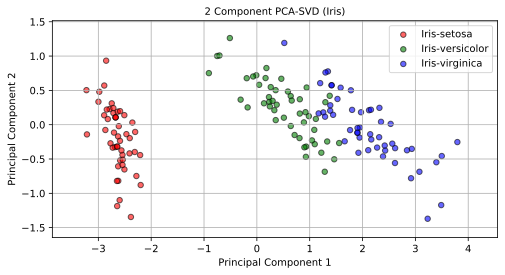

In [32]:
# Plot the 2D data
plot_123D(x_iris_2d_pca_svd, y_iris, y_iris_str, colors = ['r', 'g', 'b'],
         figsize=(8,4), alpha=0.6, title='PCA-SVD (Iris)')

### The Wine dataset

Till now, you have been using PCA on datasets whose original dimensions were relatively small. Now let's use PCA on the [Wine dataset](https://archive.ics.uci.edu/ml/datasets/wine), which consists of data from the chemical analysis of three kinds of wines. The attributes (features) of the data are quantities of 13 constituents found in each of the three types of wines. 

First, let's load the dataset and check the shape of the data and the labels.

In [33]:
from sklearn.datasets import load_wine
wine = load_wine()
x_wine = wine.data  # Each data point has 13 dimensions
y_wine = np.expand_dims(wine.target, -1)  # Numerical target label
y_wine_str = np.array([wine.target_names[i] for i in y_wine], dtype="str")  # Text description of label

print(f"Shape of x_wine: {x_wine.shape}, y_wine: {y_wine.shape}, y_wine_str: {y_wine_str.shape}")

Shape of x_wine: (178, 13), y_wine: (178, 1), y_wine_str: (178, 1)


Now let's view a few sample data points and their corresponding labels.

In [34]:
random_idx = np.random.choice(178, 10)
for idx in random_idx:
    print(f"Data: {[d for d in x_wine[idx]]} \t Label: {y_wine_str[idx]}")

Data: [13.17, 2.59, 2.37, 20.0, 120.0, 1.65, 0.68, 0.53, 1.46, 9.3, 0.6, 1.62, 840.0] 	 Label: ['class_2']
Data: [11.41, 0.74, 2.5, 21.0, 88.0, 2.48, 2.01, 0.42, 1.44, 3.08, 1.1, 2.31, 434.0] 	 Label: ['class_1']
Data: [12.25, 1.73, 2.12, 19.0, 80.0, 1.65, 2.03, 0.37, 1.63, 3.4, 1.0, 3.17, 510.0] 	 Label: ['class_1']
Data: [12.85, 1.6, 2.52, 17.8, 95.0, 2.48, 2.37, 0.26, 1.46, 3.93, 1.09, 3.63, 1015.0] 	 Label: ['class_0']
Data: [13.23, 3.3, 2.28, 18.5, 98.0, 1.8, 0.83, 0.61, 1.87, 10.52, 0.56, 1.51, 675.0] 	 Label: ['class_2']
Data: [12.87, 4.61, 2.48, 21.5, 86.0, 1.7, 0.65, 0.47, 0.86, 7.65, 0.54, 1.86, 625.0] 	 Label: ['class_2']
Data: [14.1, 2.02, 2.4, 18.8, 103.0, 2.75, 2.92, 0.32, 2.38, 6.2, 1.07, 2.75, 1060.0] 	 Label: ['class_0']
Data: [13.03, 0.9, 1.71, 16.0, 86.0, 1.95, 2.03, 0.24, 1.46, 4.6, 1.19, 2.48, 392.0] 	 Label: ['class_1']
Data: [11.66, 1.88, 1.92, 16.0, 97.0, 1.61, 1.57, 0.34, 1.15, 3.8, 1.23, 2.14, 428.0] 	 Label: ['class_1']
Data: [12.29, 2.83, 2.22, 18.0, 88.0, 2

### Task 3.2: PCA with SVD for the Wine dataset

Use the function `pca_svd` that you wrote earlier to perform PCA using SVD on the 178 data points of the Wine dataset to get a projection of the Wine dataset in a 2D space (use `reduced_dim=2`).

In [35]:
# Store the returned values in 
#`x_wine_2d_pca_svd`, `VT_wine_2d_pca_svd`, `VT_wine_reduced_2d_pca_svd`, `x_mean_wine_2d_pca_svd`

x_wine_2d_pca_svd, VT_wine_2d_pca_svd, VT_wine_reduced_2d_pca_svd, x_mean_wine_2d_pca_svd = \
None, None, None, None

### BEGIN SOLUTION

x_wine_2d_pca_svd, VT_wine_2d_pca_svd, VT_wine_reduced_2d_pca_svd, x_mean_wine_2d_pca_svd = \
pca_reduce_svd(x_wine, reduced_dim=2)

### END SOLUTION

In [36]:
# Test for PCA SVD on the Wine dataset
assert x_wine_2d_pca_svd.shape==(178,2), \
f"x_wine_2d_pca_svd should be of shape (178,2) but is of shape {x_wine_2d_pca_svd.shape}"

assert VT_wine_reduced_2d_pca_svd.shape==(2,13), \
f"VT_wine_reduced_2d_pca_svd should be of shape (2,13) but is of shape {VT_wine_reduced_2d_pca_svd.shape}"

assert x_mean_wine_2d_pca_svd.shape==(13,), \
f"x_mean_wine_2d_pca_svd should be of shape (13,) but is of shape {x_mean_wine_2d_pca_svd.shape}"

Plot the 2D points for the Wine dataset.

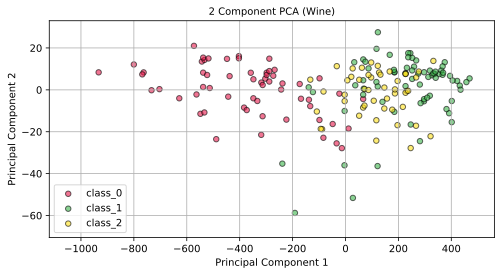

In [37]:
# Now plot the results
plot_123D(x_wine_2d_pca_svd, y_wine, 
          y_labels=y_wine_str,
          colors=['#e6194b', '#3cb44b', '#ffe119'], figsize=(8,4), alpha=0.6, title='PCA (Wine)')

You will see a plot in which the 3 different classes are not clearly separated.

<a href=#objectives> [go to top] </a>
## Part 4: Linear Discriminant Analysis<a name='lda' />

With Linear Discriminant Analysis (LDA), we can overcome the problem that we saw in the last plots - the points of the different classes are not clearly separated. 

What is the goal of LDA?
- Perform dimensionality reduction while preserving as much of the class discriminatory information as possible
- Seeks to find directions along which the classes are best separated
- Takes into consideration the scatter within-classes but also the scatter between-classes

For this exercise, we will be reusing code from [here](https://sebastianraschka.com/Articles/2014_python_lda.html) (this link was shared in slide #19 of the lecture). But instead of working with the Iris dataset, we will use the Wine dataset that we used in the previous example. The end objective is to see if LDA produces a plot in which the data points belonging to different classes can be more easily demarcated than in the plot produced by PCA (task 3.2).

You also have to make the `lda_reduce` function generic, so that it can work for any dataset and can compute the LDA components for any valid value of `reduced_dim`.

In [38]:
def lda_reduce(x, y, reduced_dim):
    """
    Performs dimensionality reduction using Linear Discriminant Analysis

    :param: x: input data (shape: [num_observations, orig_dim])
    :param: y: input labels (shape: [num_observations, 1])
    :param: reduced_dim: The dimension of the reduced data (int)
    
    :returns: x_reduced: Reduced LDA components (shape: [num_observations, reduced_dim])
    """
    
    num_observations = x.shape[0]
    orig_dim = x.shape[1]
    num_classes = np.unique(y).ravel().shape[0]
    
    print(f"num_observations: {num_observations}, orig_dim: {orig_dim}, num_classes: {num_classes}")

    #####################################################################
    
    # Step 1:  Compute the mean vectors for each class (each mean vector should be of shape (orig_dim,))
    #          and the number of such mean vectors should be `num_classes` (number of unique labels))
    mean_vectors = []

    ### BEGIN SOLUTION
    for cl in range(num_classes):
        mean_vectors.append(np.mean(x[y.ravel()==cl, :], axis=0))
    ### END SOLUTION
    
    # Test step 1:
    assert len(mean_vectors)==num_classes, f"mean_vectors should have {num_classes} elements"
    for m in mean_vectors:
        assert m.shape==(orig_dim,), f"Each mean vector should have the shape ({orig_dim},)"
    
    #####################################################################
    
    # Step 2:  Use `orig_dim` and `num_classes` to compute the within-class scatter matrix `S_W`
    #          The shape of `S_W` should be (orig_dim, orig_dim)
    S_W = None
    
    ### BEGIN SOLUTION
    S_W = np.zeros((orig_dim,orig_dim))
       
    for cl in range(num_classes):
        x_cl = x[y.ravel()==cl, :] - mean_vectors[cl]
        S_W += (x_cl.shape[0]-1) * np.cov(x_cl, rowvar=False)
    ### END SOLUTION
    
    # Test step 2:
    assert S_W.shape==(orig_dim,orig_dim), \
    f"S_W has the shape {S_W.shape} but it should be {(orig_dim,orig_dim)}"

    #####################################################################
    
    # Step 3:  Compute the overall mean of `x` (along the rows). The shape should be (1,orig_dim)
    overall_mean = None
    
    ### BEGIN SOLUTION
    overall_mean = np.mean(x, axis=0)
    ### END SOLUTION
    
    # Test step 3:
    assert overall_mean.shape==(orig_dim,), \
    f"overall_mean has the shape {overall_mean.shape} but it should be {(1,orig_dim)}"

    #####################################################################

    # Step 4:  Compute the between-class scatter matrix `S_B`
    S_B = None
    
    ### BEGIN SOLUTION
    S_B = np.zeros((orig_dim,orig_dim))
    for i,mean_vec in enumerate(mean_vectors):  
        n = x[y.ravel()==i+1,:].shape[0]
        mean_vec = mean_vec.reshape(orig_dim,1) # make column vector
        overall_mean = overall_mean.reshape(orig_dim,1) # make column vector
        S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)
    ### END SOLUTION
    
    # Test step 4:
    assert S_B.shape==(orig_dim,orig_dim), \
    f"S_B has the shape {S_B.shape} but it should be {(orig_dim,orig_dim)}"
        
    #####################################################################

    # Step 5:  Compute the eigenvalues and eigenvectors from the scatter matrices `S_W` and `S_B`
    eig_vals, eig_vecs = None, None
    
    ### BEGIN SOLUTION
    eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
    ### END SOLUTION
    
    # Make sure we are using only the real parts of the eigen vectors
    eig_vecs = np.real(eig_vecs.real)

    # Test step 5:
    assert eig_vals.shape==(orig_dim,), \
    f"eig_vals has the shape {eig_vals.shape} but it should be {(orig_dim,)}"

    assert eig_vecs.shape==(orig_dim,orig_dim), \
    f"eig_vecs has the shape {eig_vecs.shape} but it should be {(orig_dim,orig_dim)}"
    

    #####################################################################
    
    # Step 6:  Compute tuples of eigenvalues and corresponding eigenvectors and put 
    #          these tuples in a list called `eig_pairs`
    
    eig_pairs = None
    
    ### BEGIN SOLUTION
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
    ### END SOLUTION
    
    # Test step 6:
    assert len(eig_pairs)==orig_dim,\
    f"Length of eig_pairs is {len(eig_pairs)} but it should be {orig_dim}"
    for ep in eig_pairs:
        eigval = ep[0]
        eigvec = ep[1]
        assert np.isscalar(eigval), \
        f"eigval should be a scalar but its value is {eigval}"
        assert eigvec.shape==(orig_dim,), \
        f"eigvec should have the shape (orig_dim,) but its shape is {eigvec.shape}"

    #####################################################################

    # Step 7:  Sort the list of (eigenvalue, eigenvector) tuples from high to low eigenvalues
    
    ### BEGIN SOLUTION
    eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)
    ### END SOLUTION

    # Test step 7:
    assert len(eig_pairs)==orig_dim,\
    f"Length of eig_pairs is {len(eig_pairs)} but it should be {orig_dim}"
    for ep in eig_pairs:
        eigval = ep[0]
        eigvec = ep[1]
        assert np.isscalar(eigval), \
        f"eigval should be a scalar but its value is {eigval}"
        assert eigvec.shape==(orig_dim,), \
        f"eigvec should have the shape (orig_dim,) but its shape is {eigvec.shape}"    
        
    #####################################################################
        
    # Step 8:  Create a new matrix `W` by stacking the top `reduced_dim` eigenvectors 
    #          from the sorted list `eig_pairs`
    #          W should have the shape (orig_dim, reduced_dim)
    W = None
    
    ### BEGIN SOLUTION
    eig_pairs_list = []
    for dim in range(reduced_dim):
        eig_pairs_list.append(eig_pairs[dim][1].reshape(orig_dim,1))
    W = np.hstack(eig_pairs_list)
    ### END SOLUTION

    # Test step 8:
    assert W.shape==(orig_dim, reduced_dim), \
    f"W must have the shape (orig_dim, reduced_dim) but its shape is {W.shape}"
    
    #####################################################################
    
    # Step 9:  Obtain the new features (i.e. LDA components) by taking the dot product of 
    #          the original data `x `and the matrix `W` from step 8
    x_reduced = None
    
    ### BEGIN SOLUTION
    x_reduced = x.dot(W)
    ### END SOLUTION
    
    # Test step 9:
    assert x_reduced.shape==(num_observations, reduced_dim), \
    f"x_reduced must have the shape (num_observations, reduced_dim) but its shape is {x_reduced.shape}"
    
    #####################################################################

    return x_reduced, eig_vals, eig_vecs, eig_pairs

In [39]:
x_wine_2d_lda, wine_eig_vals, wine_eig_vecs, wine_eig_pairs = lda_reduce(x_wine, y_wine, reduced_dim=2)

num_observations: 178, orig_dim: 13, num_classes: 3


In [40]:
# Test for lda_reduce
assert x_wine_2d_lda.shape==(178, 2), \
f"x_wine_2d_lda must have the shape (178, 2) but its shape is {x_wine_2d_lda.shape}"

Check how much of the variance in the data is explained by the sorted eigen pairs.

In [41]:
print('Percent variance explained')
wine_eigv_sum = sum(wine_eig_vals)
for i,j in enumerate(wine_eig_pairs):
    print('eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0]/wine_eigv_sum).real))

Percent variance explained
eigenvalue 1: 82.76%
eigenvalue 2: 17.24%
eigenvalue 3: 0.00%
eigenvalue 4: 0.00%
eigenvalue 5: 0.00%
eigenvalue 6: 0.00%
eigenvalue 7: 0.00%
eigenvalue 8: 0.00%
eigenvalue 9: 0.00%
eigenvalue 10: 0.00%
eigenvalue 11: 0.00%
eigenvalue 12: 0.00%
eigenvalue 13: 0.00%


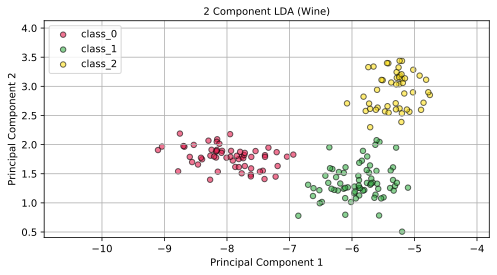

In [42]:
plot_123D(x_wine_2d_lda, y_wine, 
          y_labels=y_wine_str,
          colors=['#e6194b', '#3cb44b', '#ffe119'], figsize=(8,4), alpha=0.6, title='LDA (Wine)')

From the above plot, we can see that the 2D LDA components for the wine dataset are clearly separated.

Now let's run our LDA code for the Iris dataset and check the resulting plot.

In [43]:
x_iris_2d_lda, iris_eig_vals, iris_eig_vecs, iris_eig_pairs = lda_reduce(x_iris, y_iris, reduced_dim=2)

num_observations: 150, orig_dim: 4, num_classes: 3


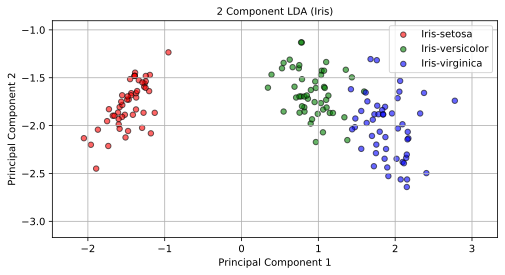

In [44]:
plot_123D(x_iris_2d_lda, y_iris, 
          y_labels=y_iris_str,
          colors=['r', 'g', 'b'], figsize=(8,4), alpha=0.6, title='LDA (Iris)')

Compared to the result we got using PCA, the result of using LDA is better at separating the data points of the different classes in the lower dimensional space.

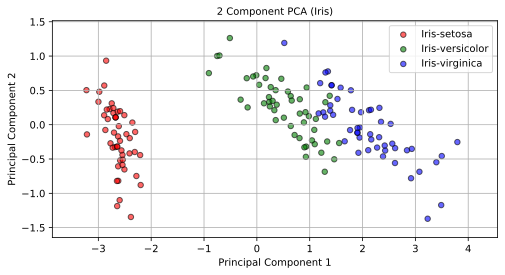

In [45]:
# Plot the 2D data
plot_123D(x_iris_2d_pca, y_iris, 
          y_labels=y_iris_str, 
          colors = ['r', 'g', 'b'], figsize=(8,4), alpha=0.6, title='PCA (Iris)')